> 이 문서의 폰트크기는 브라우저 인쇄시 인쇄 배율 80%로 최적화 되어 있음

## 이 부분은 강의 내용과 관계 없지만 여기서부터 실행 시키세요.(Time stamp 프로그램)

In [1]:
import time

a=[]

def timestamp():
    now = time.time()
    now = time.localtime(now)
    a.append(now)
    return

timestamp()

In [2]:
# multi line 출력을 위한 셀 -- 필요시 주석해제 후 이 셀을 실행시키기 바람
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

#  Language Model  : nn.LSTM 사용 버전

> 1. 훈련데이터 전처리하기
> 2. 모델 제작
> 3. 모델 훈련
     

# 1. 학습데이터 제작

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

## (1) 원시 코퍼스
- 여기서는 단순히 한개의 문장을 포함한 문자열을 원시 코퍼스로 활용

In [4]:
corpus = "Honest is the best policy for success"

## (2) 토큰화 코퍼스 제작

In [5]:
corpus_tokenized = corpus.split()
corpus_tokenized

['Honest', 'is', 'the', 'best', 'policy', 'for', 'success']

## (2) 어휘집 제작

### word2id 제작

In [6]:
word2id = {tkn: i for i, tkn in enumerate(corpus_tokenized, 1)}  # 단어에 고유한 정수 부여
word2id['<unk>'] = 0

In [7]:
print(len(word2id))
print(word2id)
print(word2id['policy'])

8
{'Honest': 1, 'is': 2, 'the': 3, 'best': 4, 'policy': 5, 'for': 6, 'success': 7, '<unk>': 0}
5


### id2word 제작

In [8]:
# ID를 단어로 바꾸기 위한 사전
id2word = {v: k for k, v in word2id.items()}
print(id2word)

{1: 'Honest', 2: 'is', 3: 'the', 4: 'best', 5: 'policy', 6: 'for', 7: 'success', 0: '<unk>'}


In [9]:
print(len(id2word))
print(id2word[4])

8
best


## (3)  코드화 코퍼스 제작

In [10]:
corpus_encoded = [word2id[token] for token in corpus_tokenized] # 각 문자를 코드로 변환. 

In [11]:
print(corpus_encoded)

[1, 2, 3, 4, 5, 6, 7]


## (4) 학습데이터 제작

In [12]:
input_seq, label_seq = corpus_encoded[:-1], corpus_encoded[1:] # 입력 시퀀스와 레이블 시퀀스를 분리

X = torch.LongTensor(input_seq).unsqueeze(0) # 배치 차원 추가
Y = torch.LongTensor(label_seq).unsqueeze(0) # 배치 차원 추가

In [13]:
print(X)
print(Y)

tensor([[1, 2, 3, 4, 5, 6]])
tensor([[2, 3, 4, 5, 6, 7]])


# 2. 모델 제작

In [14]:
class Net(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, batch_first=True):
        super(Net, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, #
                                            embedding_dim=input_size)
        self.rnn_layer = nn.LSTM(input_size, 
                                hidden_size, 
                                batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, vocab_size) 
        
    def forward(self, x):
        ## 1. 임베딩 층
        # x : (배치 크기, 시퀀스 길이) => output : (배치 크기, 시퀀스 길이, 임베딩 차원)
        x_emb = self.embedding_layer(x)
        
        ## 2. RNN 층
        # output : (배치 크기, 시퀀스 길이, 은닉층 크기)
        # hidden (1, 배치 크기, 은닉층 크기)
        output, hidden = self.rnn_layer(x_emb)
        
        ## 3. 최종 출력층
        # output : (배치 크기, 시퀀스 길이, 단어장 크기)
        output = self.linear(output)
        
        # 4. 배치 차원 제거
        # 반환값  : (배치 크기*시퀀스 길이, 단어장 크기)
        return output.view(-1, output.size(2))

In [15]:
# 하이퍼 파라미터
VOCAB_SIZE = len(word2id)  # 단어장의 크기, 임베딩 층, 최종 출력층에 사용
INPUT_SIZE = 5             # 임베딩 된 차원의 크기 및 RNN 층 입력 차원
HIDDEN_SIZE= 20            # RNN의 은닉층 크기

In [16]:
# 모델 생성
model = Net(VOCAB_SIZE, INPUT_SIZE, HIDDEN_SIZE, batch_first=True)

# 손실함수 정의
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 + CEE 

# 옵티마이저 정의
optimizer = optim.Adam(params=model.parameters())

### 점검하기

In [17]:
# 훈련 데이터로 로 예측해보기. 가중치는 전부 랜덤 초기화 된 상태
output = model(X)

print(output)
print(output.shape)

tensor([[-0.1516, -0.0273, -0.1621,  0.1031, -0.0324,  0.0226,  0.0275, -0.1633],
        [-0.1636,  0.0468, -0.1166,  0.1207, -0.0282,  0.0340,  0.0683, -0.1438],
        [-0.1491,  0.0954, -0.1149,  0.1213, -0.0020, -0.0034,  0.0709, -0.0754],
        [-0.1175,  0.1063, -0.1009,  0.1725,  0.0546,  0.0365,  0.0463, -0.1085],
        [-0.1383,  0.0622, -0.1160,  0.1517,  0.0108,  0.0563,  0.0899, -0.1160],
        [-0.1638,  0.1184, -0.1012,  0.1754,  0.0083,  0.0251,  0.0801, -0.0790]],
       grad_fn=<ViewBackward0>)
torch.Size([6, 8])


In [18]:
# 코드 시퀀스 y를 단어 시퀀스로 변경하는 함수
decode = lambda y: [id2word.get(x) for x in y]

In [19]:
timestamp()

# 3. 모델 훈련

In [20]:
EPOCHS = 200
_INTERVAL = EPOCHS/10

log_train_loss = []

print('  Epoch   Loss              출력')
    
# 훈련 시작
for i in range(EPOCHS):
    optimizer.zero_grad()   # 기울기 초기화
    
    # 순방향 전파 및 손실값 계산
    output = model(X)
    loss = loss_function(output, Y.view(-1))  
    log_train_loss.append(loss.item()) # 로그 저장
    
    # 역방향 전파 및 가중치 갱신
    loss.backward()
    optimizer.step()
        
    if i % _INTERVAL  == 0:
        print("[{:03d}/{:3d}] {:1.5f} ".format(i+1, EPOCHS, loss), end='')
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ", " ".join([id2word[X[0, 0].item()]] + decode(pred)))  #["Honest"]


  Epoch   Loss              출력
[001/200] 2.07400   Honest the the the the the the
[021/200] 2.00406   Honest the the the policy for the
[041/200] 1.91915   Honest the the best policy for policy
[061/200] 1.78784   Honest the the best policy for success
[081/200] 1.58726   Honest policy policy best policy for success
[101/200] 1.35020   Honest is the best policy for success
[121/200] 1.10691   Honest is the best policy for success
[141/200] 0.88001   Honest is the best policy for success
[161/200] 0.69061   Honest is the best policy for success
[181/200] 0.53812   Honest is the best policy for success


In [21]:
timestamp()

### 훈련 과정의 에러(손실)을 그래프로 나타내기

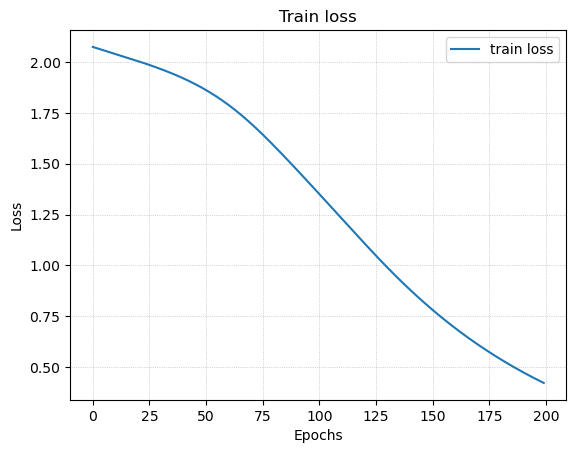

In [22]:
markers = {'train': 'o'}
x = np.arange(len(log_train_loss))
plt.plot(x, log_train_loss, label='train loss')
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim(0, 2.5)
plt.grid(True, ls=":", lw=0.5)
plt.legend(loc='upper right')

plt.show()

In [23]:
timestamp()

In [24]:
for i in a:
    now = time.strftime('%Y년 %#m월 %#d일 %#H시 %#M분 %#S초', i)
    print(now)

2023년 5월 23일 22시 9분 9초
2023년 5월 23일 22시 9분 22초
2023년 5월 23일 22시 9분 23초
2023년 5월 23일 22시 9분 25초


### 이 부분은 강의 내용과 관계 없는 부분이지만 끝까지 실행시키세요(Timestamp와 Mac address hash code 인쇄)

In [25]:
from uuid import getnode as get_mac
mac = get_mac()
mac_addr=str(mac)
import hashlib
hash_object= hashlib.sha1(mac_addr.encode('utf-8'))
signature = int(hash_object.hexdigest(), 16) % 10**8
print(str(signature))

31719826
